## Kaggle/Dacon 필사
#### 1) Model: LOWESS (Time Series Analysis의 smoothing 기법으로 사용), ARIMA
#### 2) Dataset: Tabular Playground Series - Sep 2022 (Kaggle) - 두 경쟁 매장에서 판매하는 4개의 아이템에 대한 연간 판매량을 예측
#### 3) 목적: 4개의 아이템에 대한 2021년의 판매량 예측 (예측 대상 매장은 두 곳, 매장들은 여섯 개의 다른 국가에 위치)
#### 4) 필사 Code: https://www.kaggle.com/code/azminetoushikwasi/time-series-analysis-forecasting/notebook
------------

### 0. Time Series Analysis

#### ▶ Time Series Component = Trend(추세) + Seasons(계절성) + Cycles(주기) + Error
#### ▶ 시계열 데이터가 정상성이 있어야 분석할 수 있는데, 그 조건은 다음과 같다.
##### 1. 평균이 일정
##### 2. 분산이 일정
##### 3. 계절성이 없음
####  ▶ 비정상 시계열을 정상 시계열로 바꾸는 방법: 추세나 계절성을 제거하거나 분산을 일정하게 만들어야 함. 
#### (정상 시계열이 통계적 성질 일정하므로 예측 모델이 안정적인 성능 발휘 가능)
##### 1. 시계열 회귀 분석
##### 2. 평활법(smoothing)
##### 3. 차분(differencing)
##### ※ 정상성 참고: https://medium.com/@connect2yh/%EB%8B%A4%EC%A7%9C%EA%B3%A0%EC%A7%9C-%EB%B0%B0%EC%9B%8C%EB%B3%B4%EB%8A%94-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%84-%EB%91%98%EB%9F%AC%EC%8B%BC-%EA%B8%B0%EC%B4%88-%EA%B0%9C%EB%85%90-2%ED%8E%B8-e1f62413670c
--------

### 1. EDA and Visualizations

In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


#### ▶ 날짜별 판매량 변화

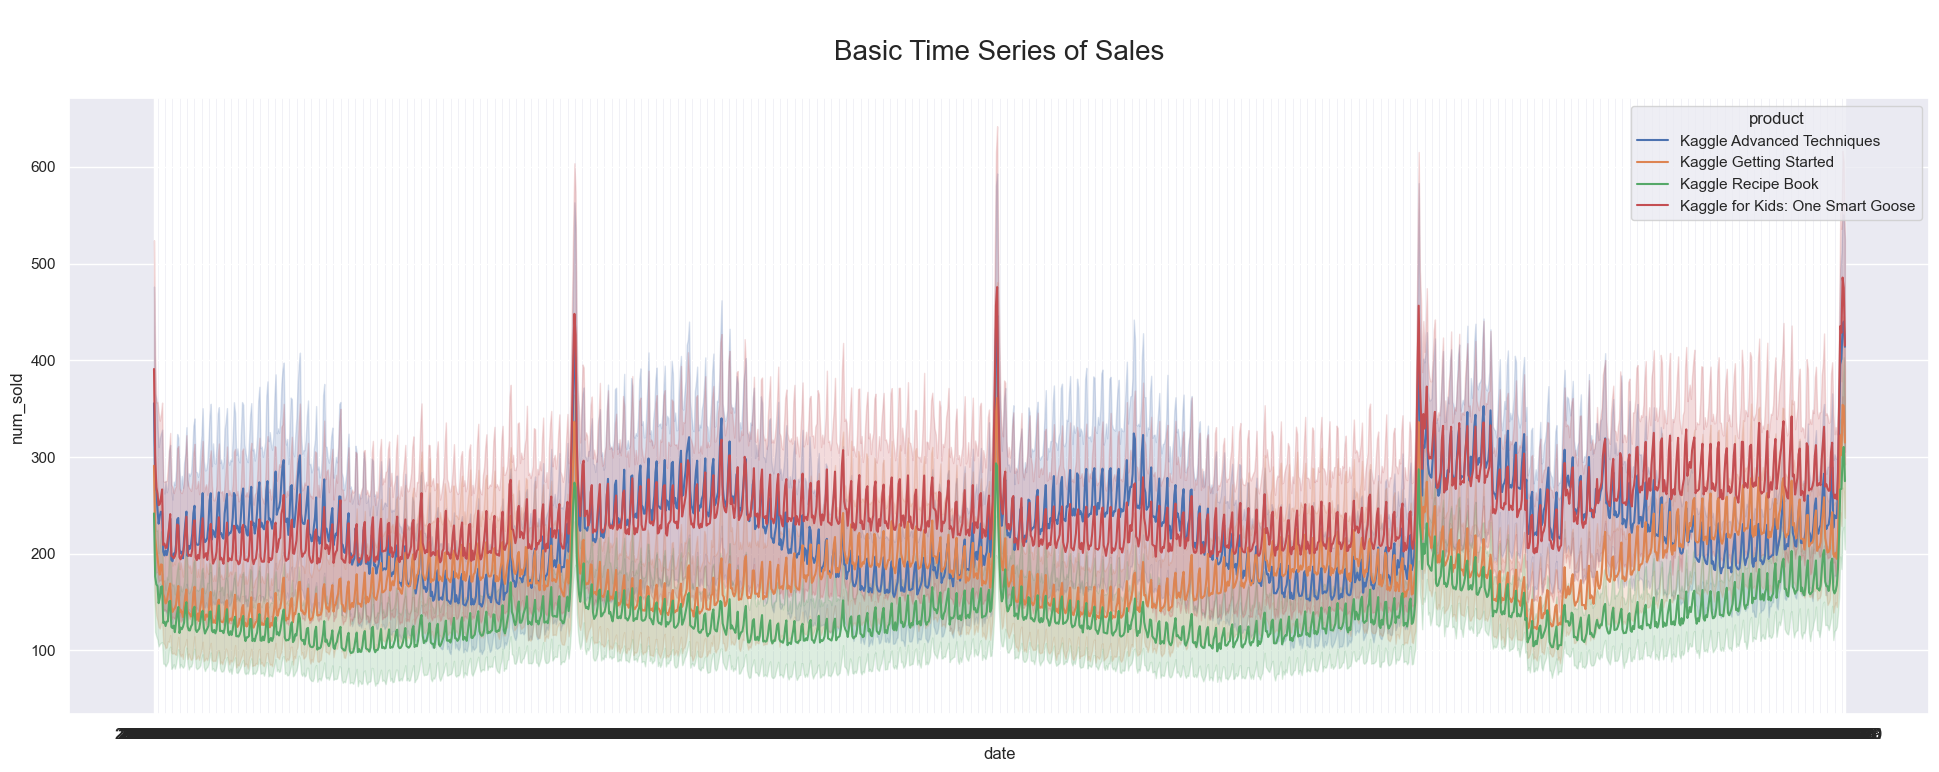

In [9]:
sns.set(rc={'figure.figsize':(24, 8)})
ax = sns.lineplot(data=train, x='date', y='num_sold', hue='product')
ax.axes.set_title('\nBasic Time Series of Sales\n', fontsize=20);

#### 판매량이 급등하는 몇몇 일자가 있다는 것을 볼 수 있음.
#### 이 그래프에서는 어떤 패턴을 발견할 수 있을까?
#### &nbsp; → Trend(추세)와 Seasonality(계절성) 확인 가능 

#### ※ 시계열 데이터 패턴 인식 방법
#### 1. Trend(추세)
##### &nbsp; 시간이 지남에 따라 지속적으로 증가하거나 감소하는 경향
##### &nbsp; ex. 판매량이 몇년 동안 꾸준히 증가하거나 감소하는 경우

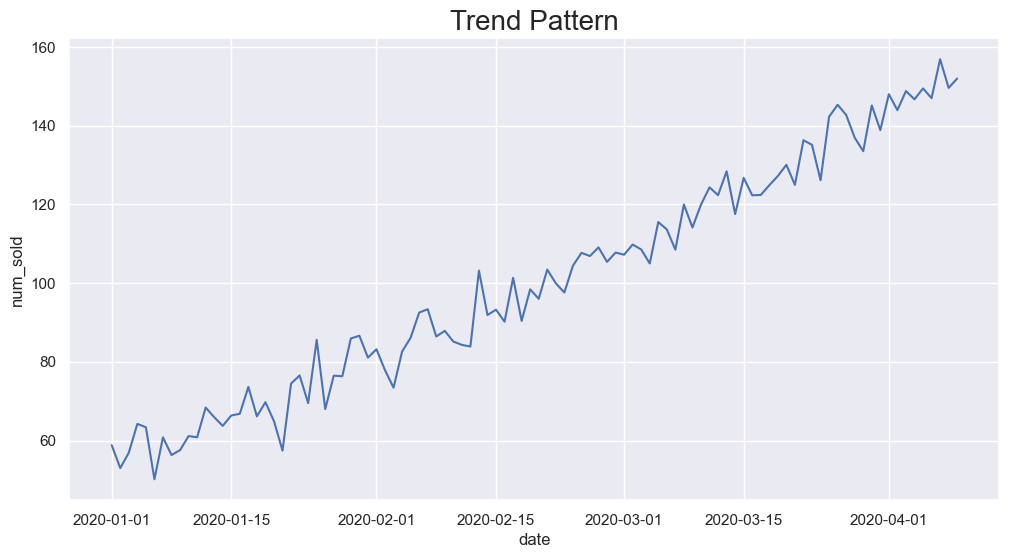

In [10]:
# 데이터 생성
np.random.seed(0)
trend_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': np.linspace(50, 150, 100) + np.random.normal(0, 5, 100)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=trend_data, x='date', y='num_sold')
ax.set_title('Trend Pattern', fontsize=20)
plt.show()

#### 2. Seasonality(계절성)
##### &nbsp; 주기적으로 반복되는 변동
##### &nbsp; ex.매년 같은 시기에 판매량 급증하는 패턴

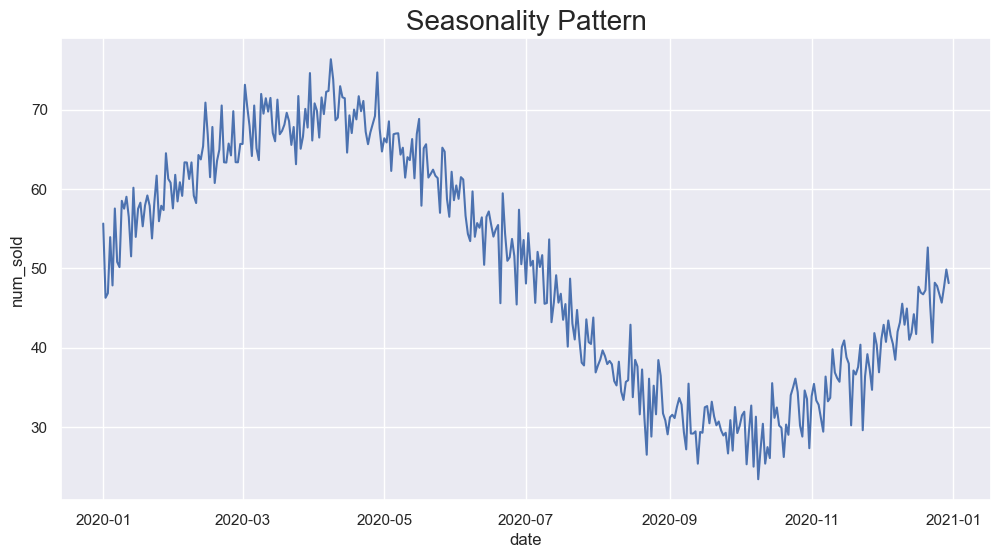

In [11]:
# 데이터 생성
seasonality_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=365),
    'num_sold': 50 + 20 * np.sin(2 * np.pi * np.arange(365) / 365) + np.random.normal(0, 3, 365)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=seasonality_data, x='date', y='num_sold')
ax.set_title('Seasonality Pattern', fontsize=20)
plt.show()


#### 3. Cyclical Patterns(순환 패턴)
##### &nbsp; 계절성과 유사하지만, 계절성보다 주기가 더 길고 일정하지 않은 패턴
##### &nbsp; ex. 경제 호황기와 불황기에 따라 판매량이 변동하는 경우

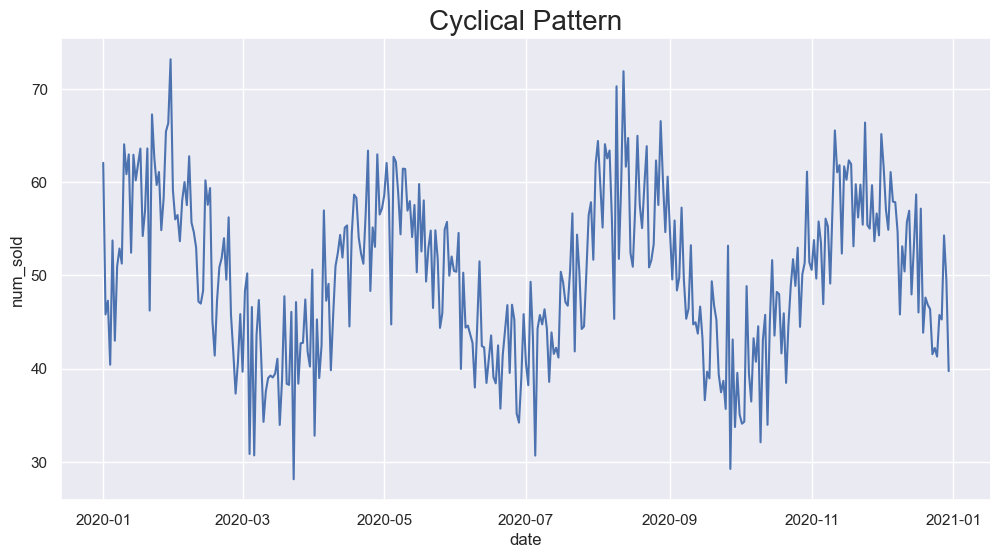

In [12]:
# 데이터 생성
cyclical_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=365),
    'num_sold': 50 + 10 * np.sin(2 * np.pi * np.arange(365) / 100) + np.random.normal(0, 5, 365)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=cyclical_data, x='date', y='num_sold')
ax.set_title('Cyclical Pattern', fontsize=20)
plt.show()


#### 4. Irregular/Random Variations(불규칙/무작위 변동)
##### &nbsp; 명확한 패턴 없이 무작위로 발생하는 변동
##### &nbsp; ex. 갑작스러운 사건으로 인한 일시적인 판매 급증

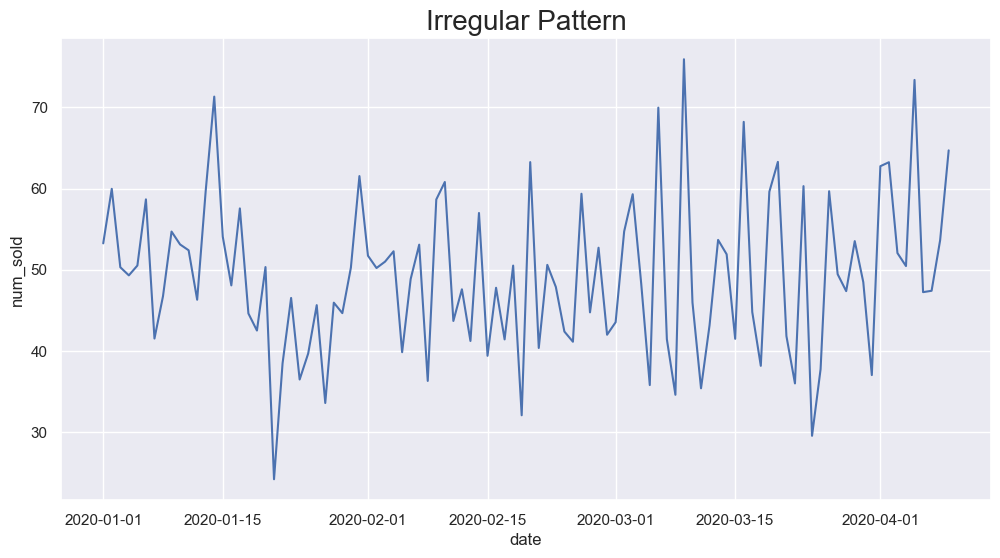

In [13]:
# 데이터 생성
irregular_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': 50 + np.random.normal(0, 10, 100)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=irregular_data, x='date', y='num_sold')
ax.set_title('Irregular Pattern', fontsize=20)
plt.show()


#### 5. Outliers(이상치)
##### &nbsp; 현저히 다른 데이터 포인트
##### &nbsp; ex. 특정 프로포션으로 특정 날의 판매량이 급증하는 경우

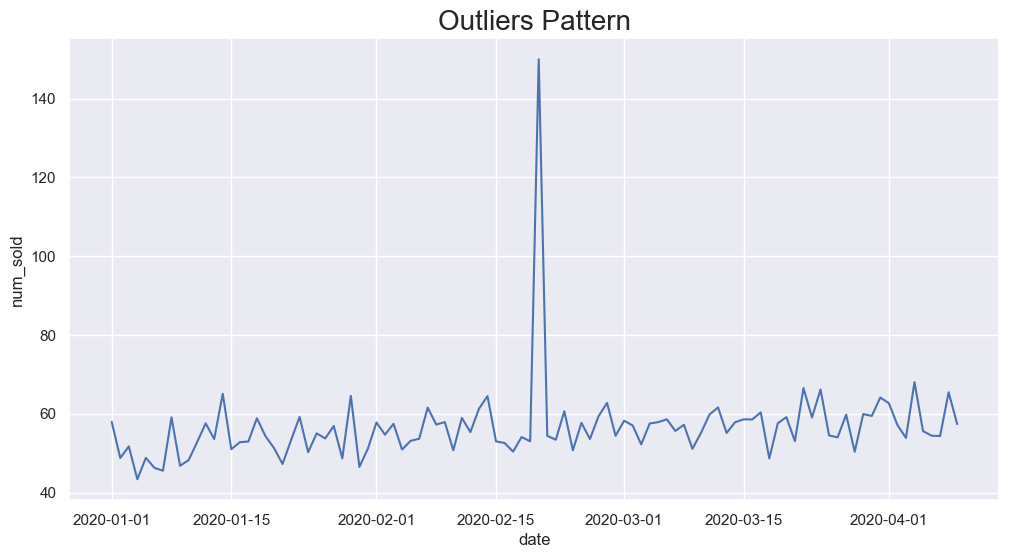

In [14]:
# 데이터 생성
outliers_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': np.linspace(50, 60, 100) + np.random.normal(0, 5, 100)
})
outliers_data.loc[50, 'num_sold'] = 150  # 이상치 추가

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=outliers_data, x='date', y='num_sold')
ax.set_title('Outliers Pattern', fontsize=20)
plt.show()


#### 6. Level Shifts(수준 변동)
##### &nbsp; 특정 시점 이후로 데이터 평균 수준이 급격히 변하는경우 
##### &nbsp; ex. 새로운 마케팅 캠페인 이후 판매량이 지속적으로 높은 수준으로 유지되는 경우

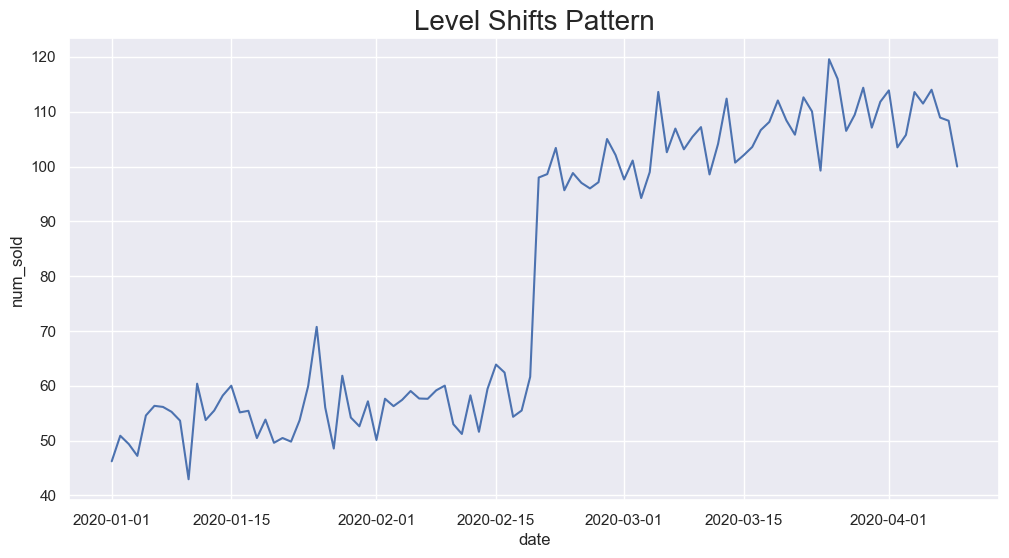

In [15]:
# 데이터 생성
level_shifts_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': np.concatenate([np.linspace(50, 60, 50), np.linspace(100, 110, 50)]) + np.random.normal(0, 5, 100)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=level_shifts_data, x='date', y='num_sold')
ax.set_title('Level Shifts Pattern', fontsize=20)
plt.show()


#### 7. Volatility Clustering(변동성 클러스터링)
##### &nbsp; 일정 기간 동안 변동성이 큰 데이터 포인트가 집중되어 있는 확인 
##### &nbsp; ex. 제품 출시 초기의 높은 변동성이 안정기로 전환되는 경우

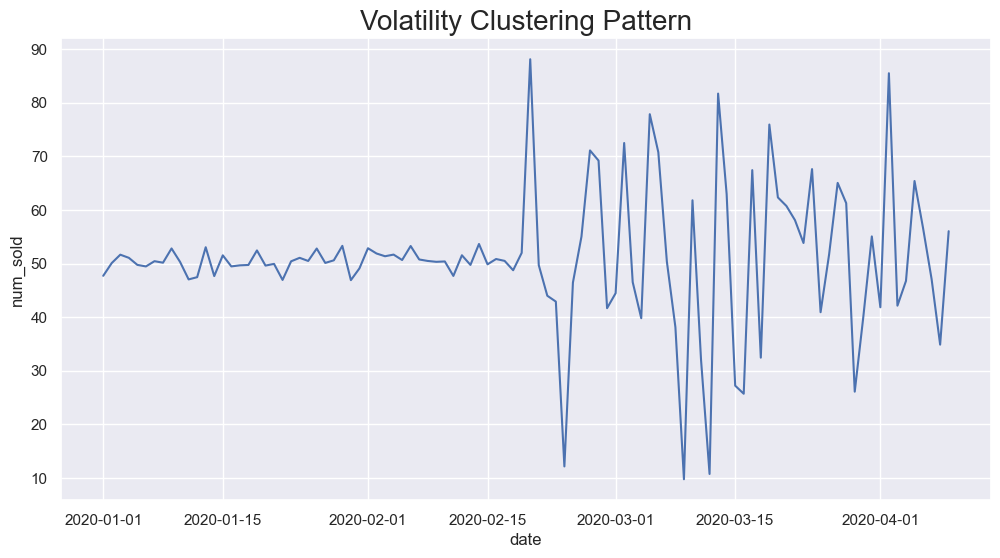

In [16]:
# 데이터 생성
volatility_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': np.concatenate([np.random.normal(50, 2, 50), np.random.normal(50, 20, 50)])
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=volatility_data, x='date', y='num_sold')
ax.set_title('Volatility Clustering Pattern', fontsize=20)
plt.show()


#### 8. Stationarity(정상성)
##### &nbsp; 데이터의 평균과 분산이 시간에 따라 일정하게 유지
##### &nbsp; ex. 꾸준한 수요를 가진 제품의 안정적인 판매량

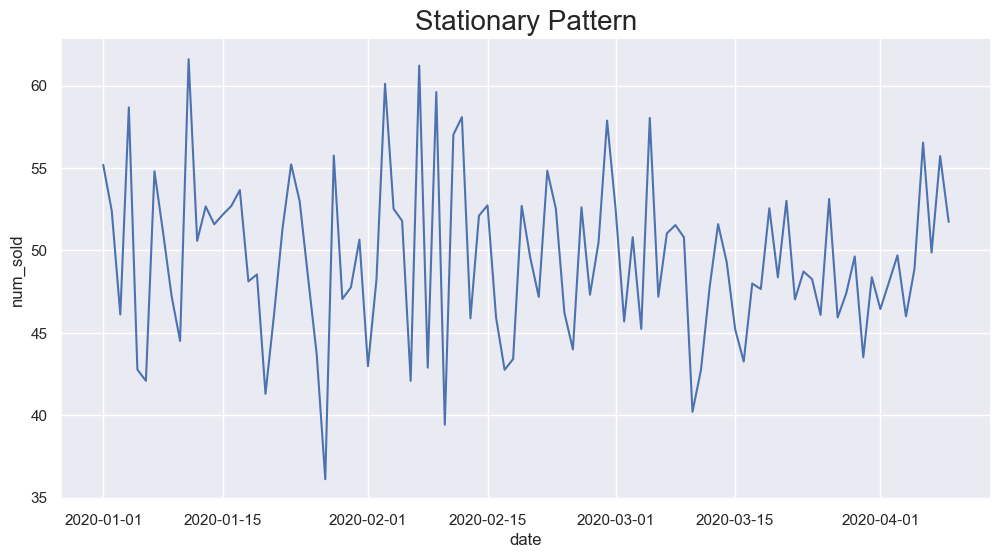

In [17]:
# 데이터 생성
stationary_data = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'num_sold': 50 + np.random.normal(0, 5, 100)
})

# 시각화
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.lineplot(data=stationary_data, x='date', y='num_sold')
ax.set_title('Stationary Pattern', fontsize=20)
plt.show()


#### ▶ 특정 데이터의 Trend 확인 및 제거
##### 특정 데이터: 나라-벨기에, 상품-Kaggle Advanced Techniques, 상점-KaggleMart

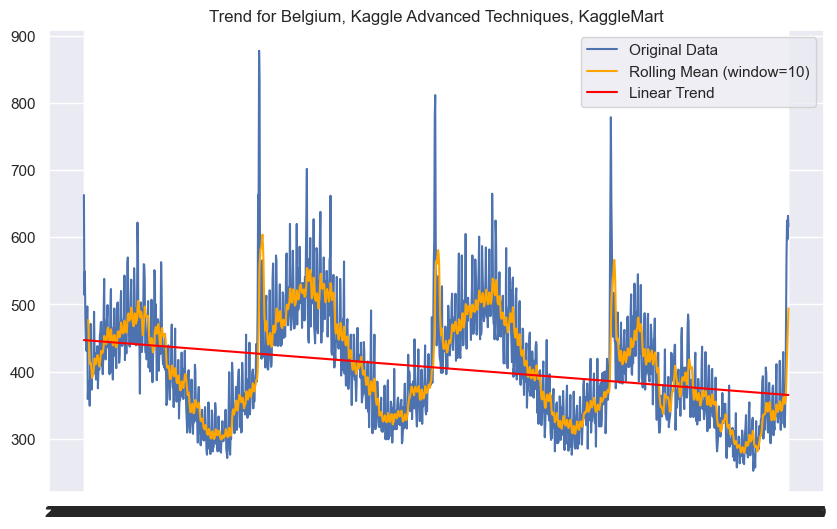

In [26]:
df = train[(train['country'] == 'Belgium') & 
           (train['product'] == 'Kaggle Advanced Techniques') & 
           (train['store'] == 'KaggleMart')]

# 추세 확인
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['num_sold'], label='Original Data')

# 이동 평균 계산 및 추가
rolling_mean = df['num_sold'].rolling(window=10).mean()
plt.plot(df['date'], rolling_mean, label='Rolling Mean (window=10)', color='orange')

# 선형 회귀선을 추가하여 추세 확인
coefficients = np.polyfit(df.index, df['num_sold'], 1)
trend = np.polyval(coefficients, df.index)
plt.plot(df['date'], trend, label='Linear Trend', color='red')

plt.legend()
plt.title('Trend for Belgium, Kaggle Advanced Techniques, KaggleMart')
plt.show()

#### ※ 선형추세를 제거하는 함수: signal.detrend

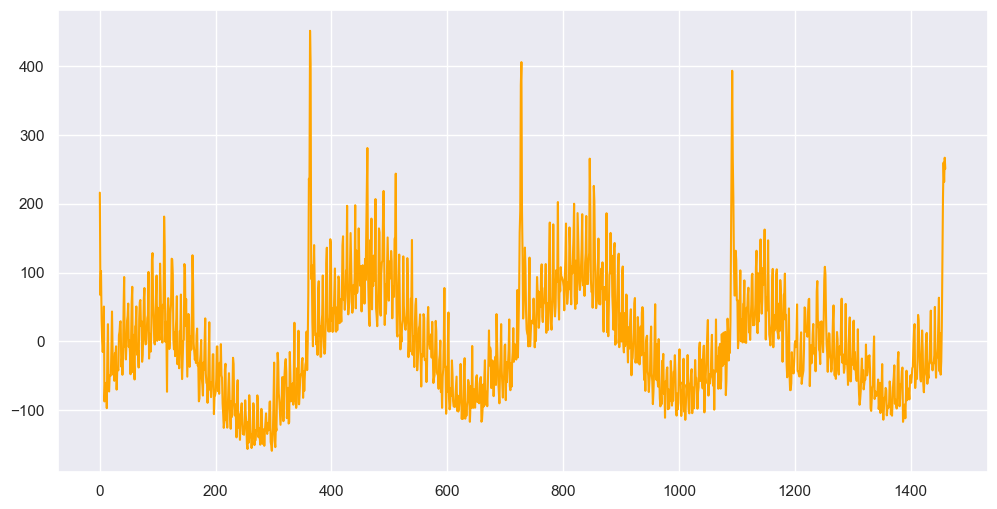

In [40]:
#추세 제거
from scipy import signal

detrended = signal.detrend(df.num_sold.values)
plt.plot(detrended, color='orange')

plt.show()

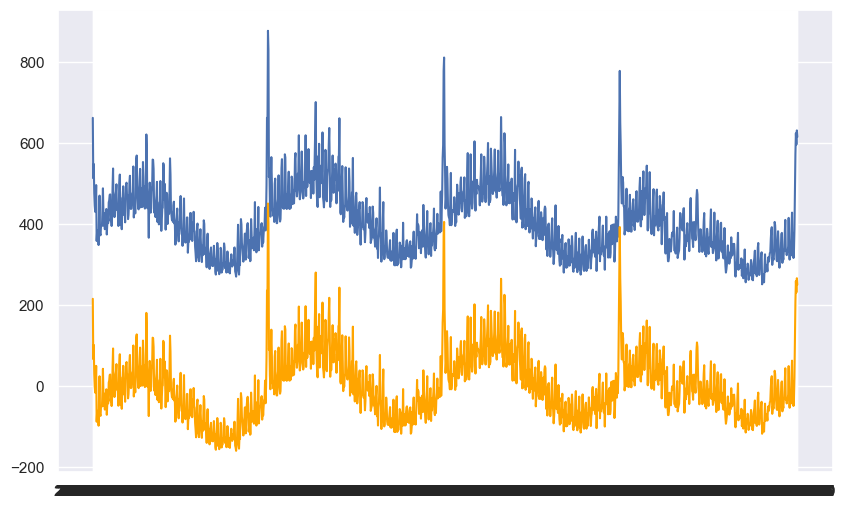

In [41]:
#비교
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['num_sold'], label='Original Data')
plt.plot(df['date'], detrended, label='Detrended Data', color='orange')
plt.show()

In [37]:
# 제거된 데이터의 평균 확인
mean_detrended = np.mean(detrended)
mean_original = np.mean(df['num_sold'])

print(f"Mean of original data: {mean_original}")
print(f"Mean of detrended data: {mean_detrended}")

Mean of original data: 405.895961670089
Mean of detrended data: 2.1788031869988013e-13


##### 선형추세 제거 후 평균이 0이므로 평균이 일정함.

#### ▶ 특정 데이터의 Seasonality 확인 및 제거

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 0 to 70080
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    1461 non-null   int64 
 1   date      1461 non-null   object
 2   country   1461 non-null   object
 3   store     1461 non-null   object
 4   product   1461 non-null   object
 5   num_sold  1461 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 79.9+ KB


#### ※ 시계열 데이터를 분해하는 함수: seasonal_decompose
##### 1) Trend(추세) + Seasons(계절성) + Residuals(잔차)로 분해하는 함수
##### 2) seasonal_decompose(df, model='additive'(덧셈) or 'multiplicative'(곱셈),  extrapolate_trend='freq'(주기))
##### 3) 덧셈 모델: y(t)=T(t)+S(t)+R(t)
##### 4) 곱셈 모델: y(t)=T(t)×S(t)×R(t) --데이터의 변동 폭이 트렌드와 함께 증가하거나 감소하는 경우에 적합. 단, 데이터에 0이 있으면 사용 불가

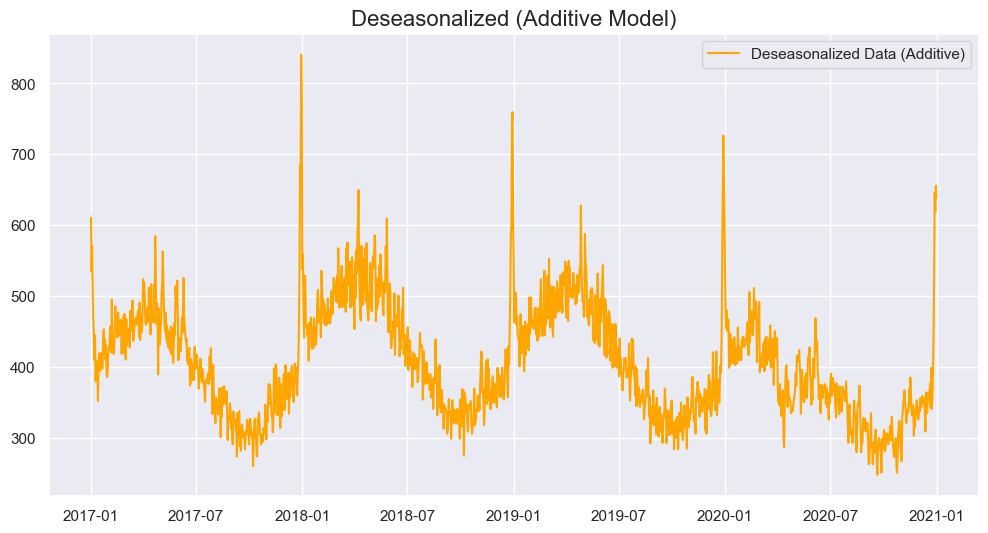

In [50]:
df = train[(train['country'] == 'Belgium')&(train['product'] == 'Kaggle Advanced Techniques')&(train['store'] == 'KaggleMart')]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(df['num_sold'], model='additive', extrapolate_trend='freq')
deseasonalized = df.num_sold.values - result_mul.seasonal

plt.plot(df.index, deseasonalized, label='Deseasonalized Data (Additive)', color='orange')
plt.title('Deseasonalized (Additive Model)', fontsize=16)
plt.legend()
plt.show()

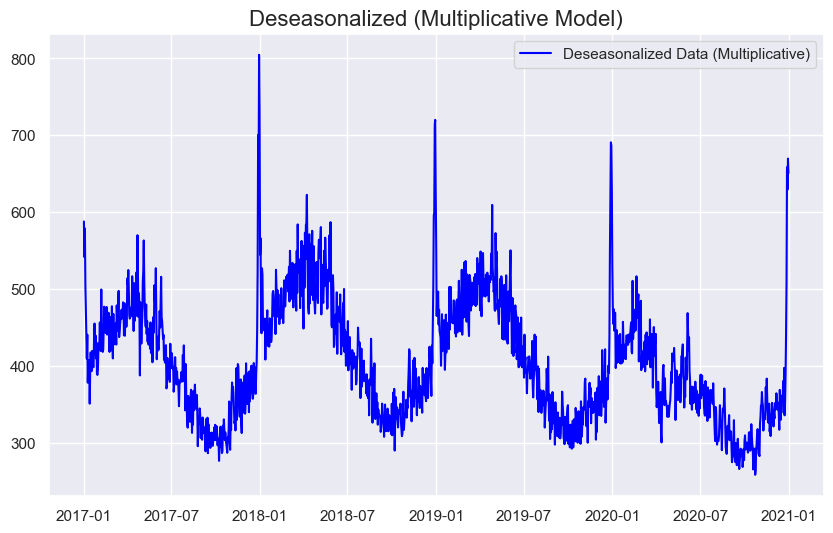

In [49]:
result_mul = seasonal_decompose(df['num_sold'], model='multiplicative', extrapolate_trend='freq')

# 시즌성을 제거한 데이터 (곱셈 모델)
deseasonalized_mul = df['num_sold'].values / result_mul.seasonal

# 비시즌화된 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index, deseasonalized_mul, label='Deseasonalized Data (Multiplicative)', color='blue')
plt.title('Deseasonalized (Multiplicative Model)', fontsize=16)
plt.legend()
plt.show()

#### ▶ 특정 데이터의 자기상관 확인
##### ※시계열에서의 자기상관
##### 1) 자기상관은 과거 값이 현재 값에 미치는 영향
##### 2) seasonality(계절성)과 trend(추세)를 가질 때 자기상관이 있음.
##### 3) 완전 무작위(white noise)일 때는 자기상관이 없음.
##### 4) 자기상관 함수(ACF)는 lag(시차) k에 따른 자기상관 계수를 계산해서 패턴 파악하는데 사용

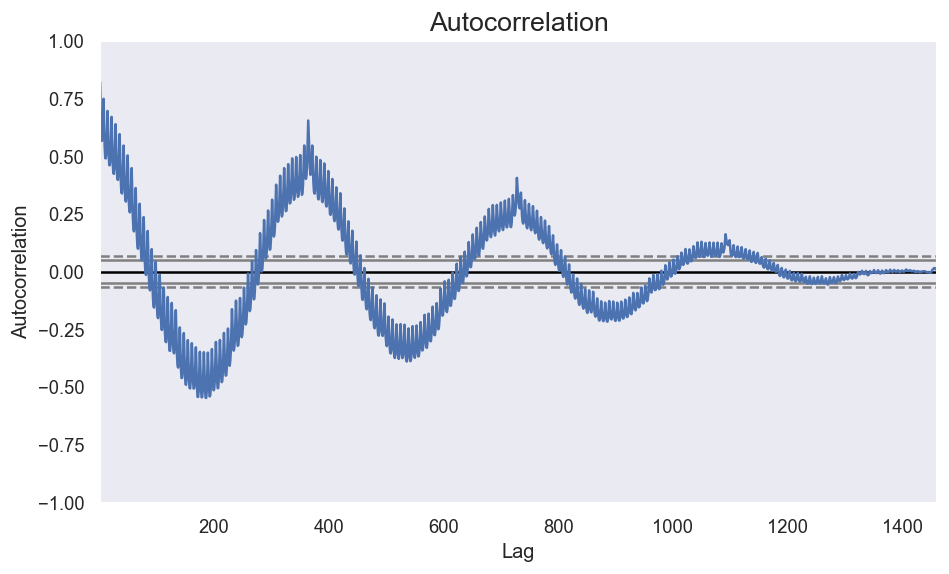

In [54]:
from pandas.plotting import autocorrelation_plot
df = train[(train['country']=='France')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.num_sold.tolist())

plt.title('Autocorrelation', fontsize=16)
plt.show()

##### 초기에 높은 자기상관을 가지므로 최근의 데이터가 서로 강한 연관을 가짐.
##### 시차가 커질수록 자기상관이 점진적으로 감소하므로 데이터가 시간이 지남에 따라 더 독립적으로 변함.
##### 물결 모양이므로 주기성이 있음.

#### ▶ Stationarity(정상성) 확인

In [56]:
df = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]

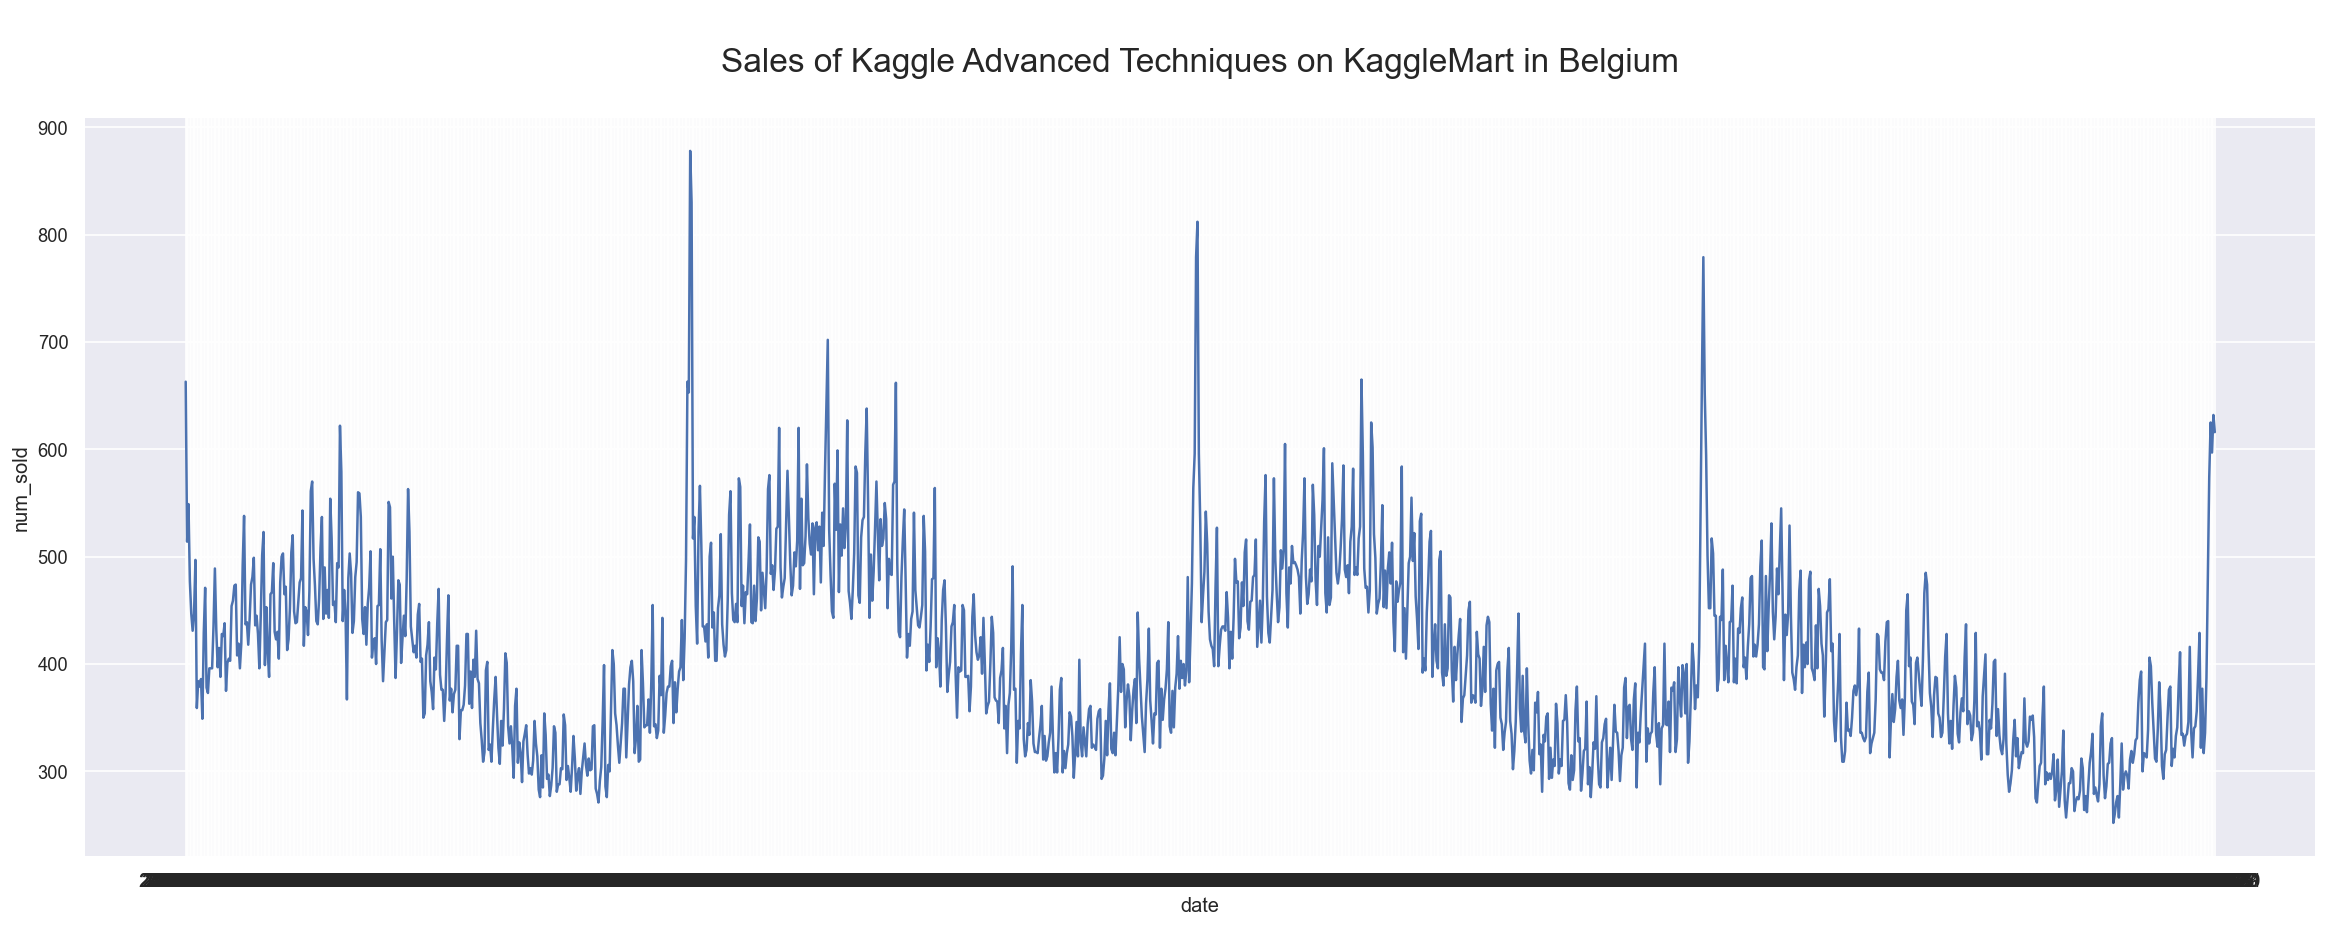

In [59]:
sns.set(rc={'figure.figsize':(24, 8)})
ax=sns.lineplot(data=df, x='date', y='num_sold')
ax.axes.set_title("\nSales of Kaggle Advanced Techniques on KaggleMart in Belgium\n", fontsize=20)
plt.show()

##### 통계적 테스트 방법인 ADF test., KPSS test, PP test으로도 정상성을 테스트할 수 있다.

#### ※ Augmented Dickey Fuller test(ADH test) 함수: adfuller
##### 1) 귀무가설: 시계열 데이터가 단위 근을 가지고 있다. (= 비정상적이다)
##### 2) p-value가 유의수준보다 작으면 귀무가설 기각한다. (=정상적이다)

In [61]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.num_sold.values, autolag='AIC') #현재 시점의 값과 과거 시점의 값들 사이의 시간 간격 길이를 AIC 기준으로 최적의 길이 선택

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:') # 다양한 유의수준
    print(f' {key}, {value}')

ADF Statistic: -2.7177853359031645
p-value: 0.07101086977865034
Critial Values:
 1%, -3.4349056408696814
Critial Values:
 5%, -2.863552005375758
Critial Values:
 10%, -2.5678411776130114


##### ADF 테스트 해석: p-value가 0.05보다 크므로 귀무 가설을 기각할 수 없다. 즉, 데이터가 비정상적이다.

#### ※ KWiatkowshi-Philips-Schnidmt-Shin(KPSS test) 함수: kpss
##### 1) 귀무가설: 시계열 데이터가 정상적이다.
##### 2) p-value가 유의수준보다 크면 귀무가설을 기각하지 않는다.(=정상적이다)

In [63]:
from statsmodels.tsa.stattools import kpss
result = kpss(df.num_sold.values, regression='c') #상수항만 포함한 모델(데이터가 평균 주위에서 변동하는지 테스트)

print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 0.887170
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Hyun\AppData\Local\Temp\ipykernel_9212\3268775006.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df.num_sold.values, regression='c')


##### KPSS 테스트 해석: p-value가 0.05보다 작으므로 귀무 가설을 기각할 수 있다. 즉, 데이터가 비정상적이다.

----

#### ※ white noise와 stationary series의 차이점
##### 평균과 분산이 시간에 따라 변하지 않는다는 차이점이 있지만, 백색 잡음은 평균이 0인 완전 무작위(패턴이 없음)
-----

#### ▶ 자기상관과 부분자기상관 시각화
##### ACF 플롯은 전반적인 상관관계를 나타내고, PACF 플롯은 특정 시차에서의 순수한 상관관계를 나타낸다.
##### lag 플롯으로도 자기상관을 나타낼 수 있다.

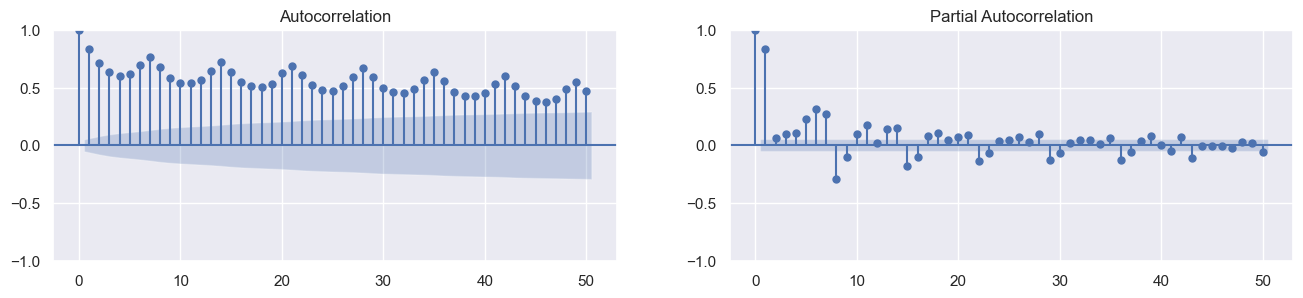

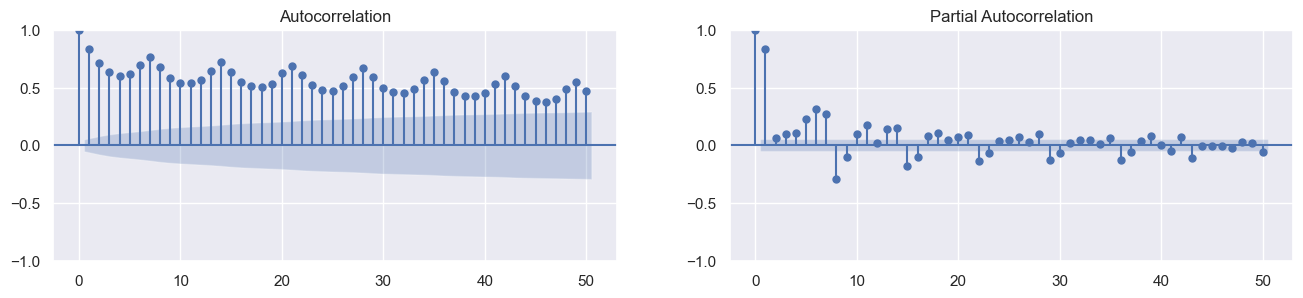

In [64]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]
df['value']=df['num_sold']

acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.value, nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

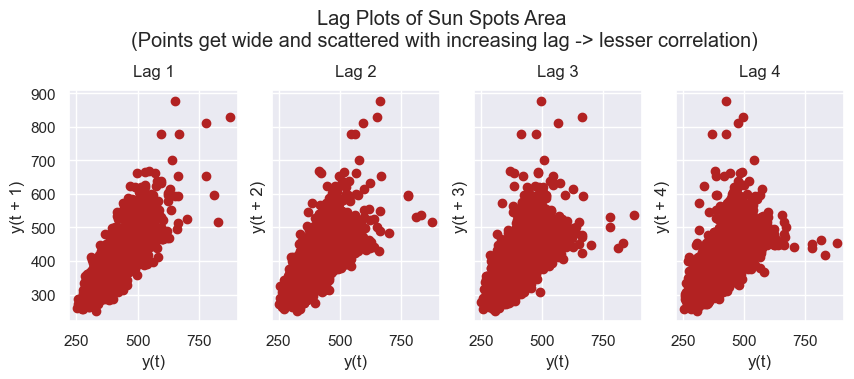

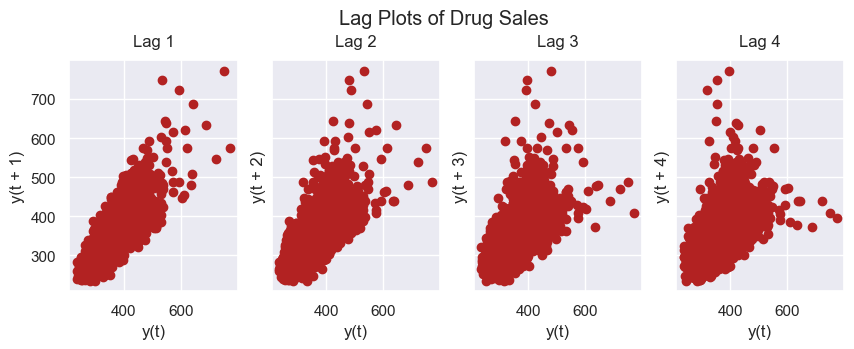

In [66]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


ss = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]
ss['value']=ss['num_sold']
a10 = train[(train['country']=='France')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]
a10['value']=a10['num_sold']


fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)  
plt.show()

---------
### 2. Smoothing

#### ▶ 평활화(smoothing) 목적
##### 1) noise를 줄이기 위해
##### 2) smoothing 버전의 데이터를 원래 데이터를 설명하는 피처로 사용 가능
##### 3) 추세를 더 잘 시각화할 수 있음

#### ▶ 평활화(smoothing) 방법
##### 1) 이동 평균
##### 2) LOESS 평활화(Localized Regression): 국소적 구간에 다항 회귀 적용
##### 3) LOWESS 평활화(Locally Weighted Regression): 국소적 회귀에서 가중치 부여
- LOWESS 순서
##### &nbsp;&nbsp;&nbsp; (1) Xi를 중심으로 너비(2k+1)의 윈도우를 만들면, (Xi-k, Yi-k), ..., (Xi, Yi), ..., (Xi+k, Yi+k)가 포함
##### &nbsp;&nbsp;&nbsp; (2) 개체들과 중심점 거리를 계산해서 개체들에게 가중치 Wj를 부여
##### &nbsp;&nbsp;&nbsp; (3) 윈도우 내에서 가중최소제곱법을 적용해서 y hat값을 예측
##### &nbsp;&nbsp;&nbsp; (4) n개의 점(X1, Y1 hat), ..., (Xi, Yi hat), ..., (Xn, Yn hat)을 선분으로 연결
- 윈도우의 상대적 크기인 frac 
##### &nbsp;&nbsp;&nbsp; (1) 0~1 사이의 값 = (2k+1)/n
##### &nbsp;&nbsp;&nbsp; (2) 값이 클수록 더 부드러운 평활화 결과를 나타낼 수 있음.(다만, 세부 변동 파악이 어려워짐.)
##### &nbsp;&nbsp;&nbsp; (3) 값이 작을수록 세부 변동을 더 잘 파악할 수 있음.(다만, 과적합 위험 존재)

- 가중치 w
##### &nbsp;&nbsp;&nbsp; (1) (1-(중심점과의 거리/윈도우 내 최대 거리)^3)^3
##### &nbsp;&nbsp;&nbsp; (2) 중심점에서 멀어질수록 가중치가 급격히 낮아짐. (거리가 윈도우 내 최대 거리에 가까워지면, 가중치가 0에 가까움)

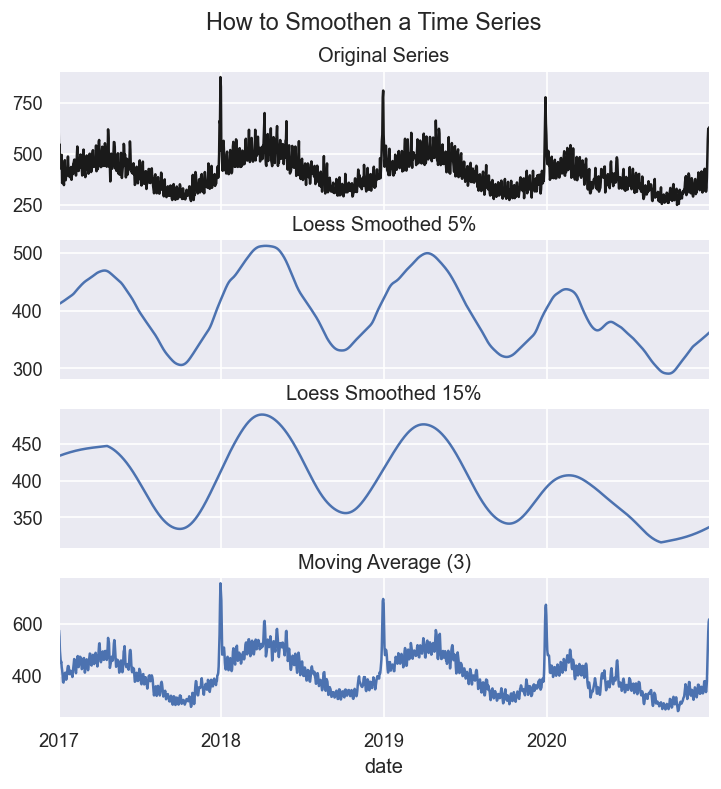

In [70]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom': False, 'axes.titlepad':5})

df = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]
df['value']=df['num_sold']
df=df.set_index('date')
df.index = pd.to_datetime(df.index)

df_orig=df.copy()

df_ma = df_orig.value.rolling(3, center=True, closed='both').mean()

df_loess_5 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.05)[:, 1], index=df_orig.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_orig['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

##### lowess frac 비율이 15%일 때 더 부드러운 선이 나타남

---------
### 3. Modeling

#### ▶ ARIMA(Auto-Regressive Integrated Moving Average) 모델
##### 1) 구성요소: AR(자기회귀 모델), MA(이동 평균), I(적분)
##### 2) Auto Regressive(AR): 과거 값들이 현재 값에 영향을 미치는 모델
- p: 이전 지연 값의 수
##### 3) Moving Average (MA): 과거 오차들이 현재 값에 영향을 미치는 모델
- q: 이전 오차 항의 지연 값의 수
##### 4) Integration (I): 데이터를 정상성 있게 만들기 위해 차분하는 과정
- d: 정상성 있게 만들기 위해 차분하는 횟수

In [71]:
df = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]
series=pd.DataFrame()
series['value']=df['num_sold']
series=series.set_index(df['date'])
series.index = pd.to_datetime(series.index)

series

,value
date,
2017-01-01,663
2017-01-02,514
2017-01-03,549
2017-01-04,477
2017-01-05,447
...,...
2020-12-27,574
2020-12-28,625
2020-12-29,597


C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1461
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7515.898
Date:                Mon, 08 Jul 2024   AIC                          15043.797
Time:                        22:10:42   BIC                          15075.514
Sample:                    01-01-2017   HQIC                         15055.628
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3193      0.020    -16.123      0.000      -0.358      -0.280
ar.L2         -0.3069      0.016    -18.621      0.000      -0.339      -0.275
ar.L3         -0.2861      0.023    -12.613      0.0

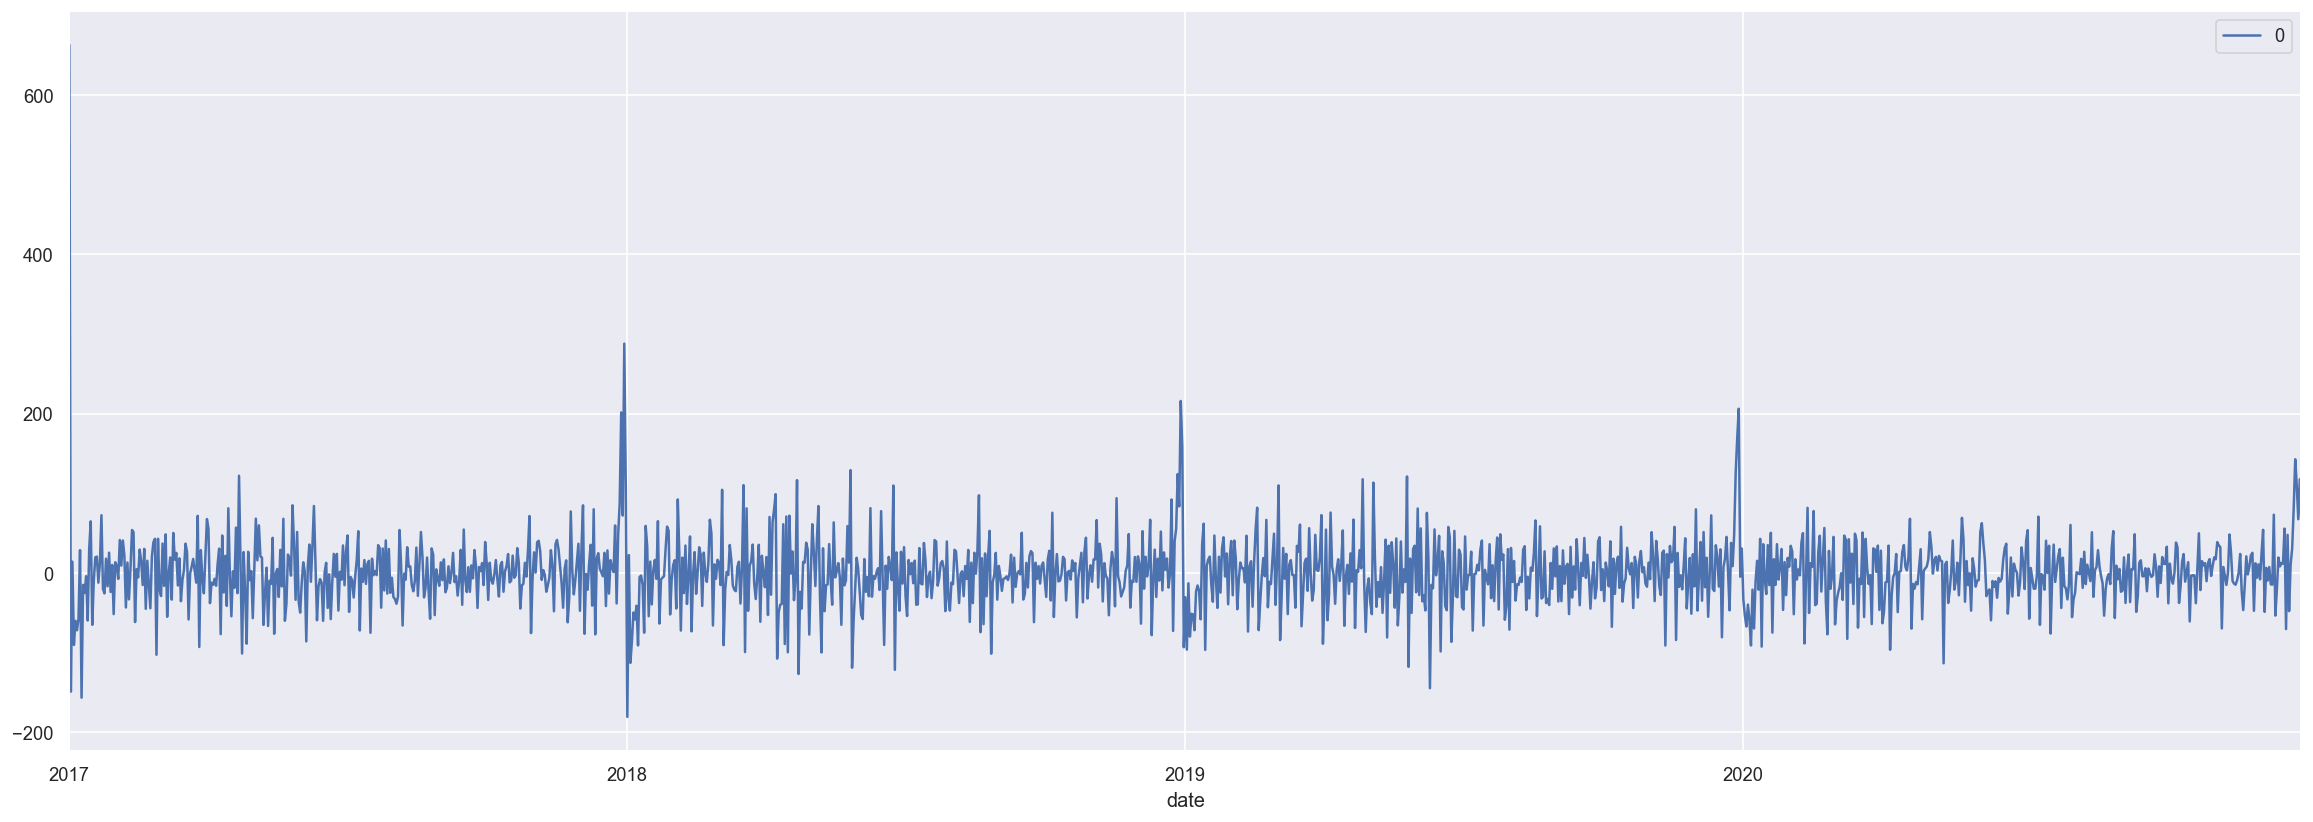

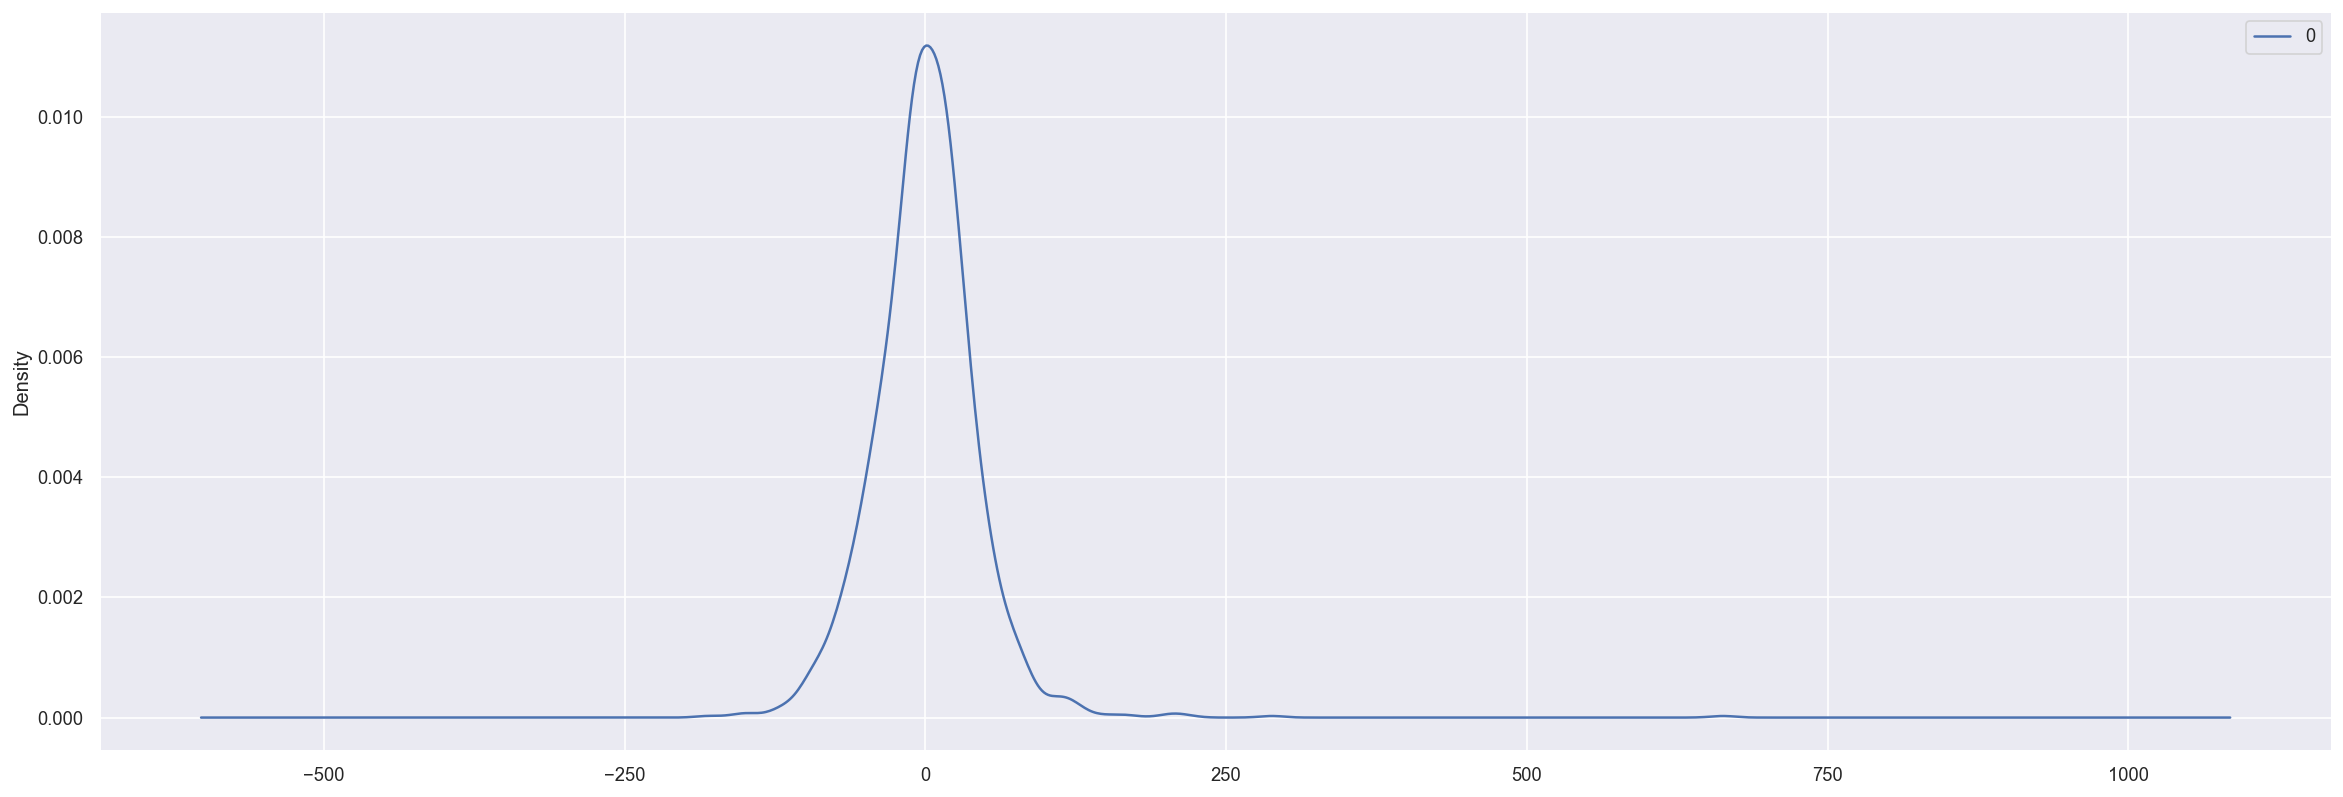

                 0
count  1461.000000
mean      0.388641
std      45.151376
min    -180.506780
25%     -23.286515
50%       0.017557
75%      23.277978
max     663.000000


In [75]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series, order=(5, 1, 0)) #p, d, q 설정
model_fit = model.fit()
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

#### SARIMAX Results 해석
##### 1) Dep. Variable (종속 변수): value
##### 2) No. Observations (관측치 수): 1461
##### 3) Model (모델): ARIMA(5, 1, 0)
##### 4) Log Likelihood (로그 우도): -7515.898
##### 5) AIC (Akaike 정보 기준): 15043.797
##### 6) BIC (Bayesian 정보 기준): 15075.514
##### 7) HQIC (Hannan-Quinn 정보 기준): 15055.628
##### 8) Sample (표본 기간): 01-01-2017 ~ 12-31-2020
##### 9) Covariance Type (공분산 유형): opg
##### 10) ar.L1 ~ ar.L5: 자기회귀 항 (lag 1부터 5까지)의 계수와 통계적 유의성
- 모든 계수가 음수로 나타나 있으며, 이는 각 시차의 값이 현재 값에 음의 영향을 미친다는 것을 의미
- p-값이 0.05보다 작으므로 모든 계수가 통계적으로 유의미
##### 11) sigma2: 오차 분산.
- 오차의 분산이 1732.3229로, 이는 모델의 예측 오차
- p-값이 0.05보다 작으므로 오차 분산도 통계적으로 유의미